# Single Neuron Models: The Leaky Integrate-and-Fire (LIF) Neuron Model

**Content creators:** Qinglong Gu, Songtin Li, Kai Chen, John Murray, Richard Naud, Arvind Kumar, 

**Content reviewers:** Xuexing Du

---
# Tutorial Objectives
This is your first tutorial implementing realistic neuron models. In this tutorial, we will build up a leaky integrate-and-fire (LIF) neuron model and study its dynamics in response to various types of inputs. In particular, we are going to write a few lines of code to:  

- simulate the LIF neuron model

- drive the LIF neuron with external inputs, such as direct currents, Gaussian white noise, and Poisson spike trains, etc.

- study how different inputs affect the LIF neuron's output (firing rate and spike time irregularity)

Here, we will especially emphasize identifying conditions (input statistics) under which a neuron can spike at low firing rates and in an irregular manner. The reason for focusing on this is that in most cases, neocortical neurons spike in an irregular manner.

In [1]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
import numpy as np


bm.set_platform('cpu')

bp.__version__

'2.4.6.post5'

In [2]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style

nma_style = {
    'figure.figsize' : (8, 6),
    'figure.autolayout' : True,
    'font.size' : 15,
    'xtick.labelsize' : 'small',
    'ytick.labelsize' : 'small',
    'legend.fontsize' : 'small',
    'axes.spines.top' : False,
    'axes.spines.right' : False,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
}
for key, value in nma_style.items():
    plt.rcParams[key] = value

my_layout = widgets.Layout()

---
# Section 1: The Leaky Integrate-and-Fire (LIF) model

## Implementation of an LIF neuron model

Now, it's your turn to implement one of the simplest mathematical model of a neuron: the leaky integrate-and-fire (LIF) model. The basic idea of LIF neuron was proposed in 1907 by Louis Édouard Lapicque, long before we understood the electrophysiology of a neuron (see a translation of [Lapicque's paper](https://pubmed.ncbi.nlm.nih.gov/17968583/) ). More details of the model can be found in the book [**Theoretical neuroscience**](http://www.gatsby.ucl.ac.uk/~dayan/book/) by Peter Dayan and Laurence F. Abbott.

The subthreshold membrane potential dynamics of a LIF neuron is described by

\begin{equation}
C_m\frac{dV}{dt} = -g_L(V-E_L) + I,\quad (1)
\end{equation}

where $C_m$ is the membrane capacitance, $V$ is the membrane potential, $g_L$ is the leak conductance ($g_L = 1/R$, the inverse of the leak resistance $R$ mentioned in previous tutorials), $E_L$ is the resting potential, and $I$ is the external input current. 

Dividing both sides of the above equation by $g_L$ gives

\begin{align}
\tau_m\frac{dV}{dt} = -(V-E_L) + \frac{I}{g_L}\,,\quad (2)
\end{align}

where the $\tau_m$ is membrane time constant and is defined as $\tau_m=C_m/g_L$. 

You might wonder why dividing capacitance by conductance gives units of time! Find out yourself why this is true.

Below, we will use Eqn.(2) to simulate LIF neuron dynamics. 

If $I$ is sufficiently strong such that $V$ reaches a certain threshold value $V_{\rm th}$, $V$ is reset to a reset potential $V_{\rm reset}< V_{\rm th}$, and voltage is clamped to $V_{\rm reset}$ for $\tau_{\rm ref}$ ms, mimicking the refractoriness of the neuron during an action potential:

$$
\text { if } \quad V\left(t_{\mathrm{sp}}\right) \geq V_{\mathrm{th}}: V(t)=V_{\text {reset }} \text { for } t \in\left(t_{\mathrm{sp}}, t_{\mathrm{sp}}+\tau_{\text {ref }}\right]
$$

where $t_{\rm sp}$ is the spike time when $V(t)$ just exceeded $V_{\rm th}$.

(__Note__: in the lecture slides, $\theta$ corresponds to the threshold voltage $V_{th}$, and $\Delta$ corresponds to the refractory time $\tau_{\rm ref}$.)

Thus, the LIF model captures the facts that a neuron:
- performs spatial and temporal integration of synaptic inputs 
- generates a spike when the voltage reaches a certain threshold
- goes refractory during the action potential
- has a leaky membrane 

The LIF model assumes that the spatial and temporal integration of inputs is linear. Also, membrane potential dynamics close to the spike threshold are much slower in LIF neurons than in real neurons. 

In [3]:
def default_pars(**kwargs):
    pars = {}
    # typical neuron parameters#
    pars['V_th'] = -55.     # spike threshold [mV]
    pars['V_reset'] = -75.  # reset potential [mV]
    pars['tau_m'] = 10.     # membrane time constant [ms]
    pars['g_L'] = 10.       # leak conductance [nS]
    pars['E_L'] = -75.      # leak reversal potential [mV]
    pars['t_ref'] = 2.       # refractory time (ms)

    # external parameters if any #
    for k in kwargs:
        pars[k] = kwargs[k]

    return pars

def default_time(duration = 200, dt =0.1):
    pars = {}
    pars['duration'] = duration
    pars['dt'] = dt 
    pars['ts'] = np.arange(0, duration, dt)
    return pars

class LIF(bp.dyn.NeuGroup):
    def __init__(self, size , E_L= -75., V_reset=-75., V_th= -55., g_L= 10., tau_m=10.,t_ref= 2.,name=None):
        super(LIF,self).__init__(size=size,name=name)
 
        #初始化参数
        self.E_L = E_L
        self.V_reset = V_reset
        self.V_th = V_th
        self.g_L  = g_L
        self.tau_m = tau_m
        self.t_ref = t_ref
 
        #初始化变量
        self.V = bm.Variable(bm.zeros(self.num) + V_reset)
        self.input = bm.Variable(bm.zeros(self.num))
        self.t_last_spike = bm.Variable(bm.ones(self.num)* -1e7) #上一次脉冲发放时刻
        self.refractory = bm.Variable(bm.zeros(self.num,dtype=bool)) #是否处于不应期
        self.spike = bm.Variable(bm.zeros(self.num,dtype=bool)) #脉冲发放状态
 
        #积分函数
        self.integral = bp.odeint(f=self.derivative,method='euler')
 
        #定义膜电位关于时间变化的微分方程
    def derivative(self,V,t,Iext):
        dvdt = (-V + self.E_L + Iext/ self.g_L) / self.tau_m
        return dvdt
 
        #更新函数
    def update(self):
        t,dt = bp.share['t'], bp.share['dt']
        refractory = (t - self.t_last_spike) <= self.t_ref #是否处于不应期
        V = self.integral(self.V,t,self.input,dt=dt) #根据时间步长更新膜电位
        V = bm.where(refractory,self.V,V)
        spike = V>self.V_th #更新脉冲状态
        self.spike.value = spike
        self.t_last_spike = bm.where(spike,t,self.t_last_spike) #更新上次脉冲时间
        self.V.value = bm.where(spike,self.V_reset,V)
        self.refractory.value = bm.logical_or(refractory,spike)
        self.input[:]=0#重置外界输入

/home/spirit/anaconda3/envs/winter/lib/python3.11/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.DSRunner is deprecated. Use brainpy.DSRunner instead.
  _deprecate(message)


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/spirit/.local/lib/python3.11/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


Text(0, 0.5, 'V')

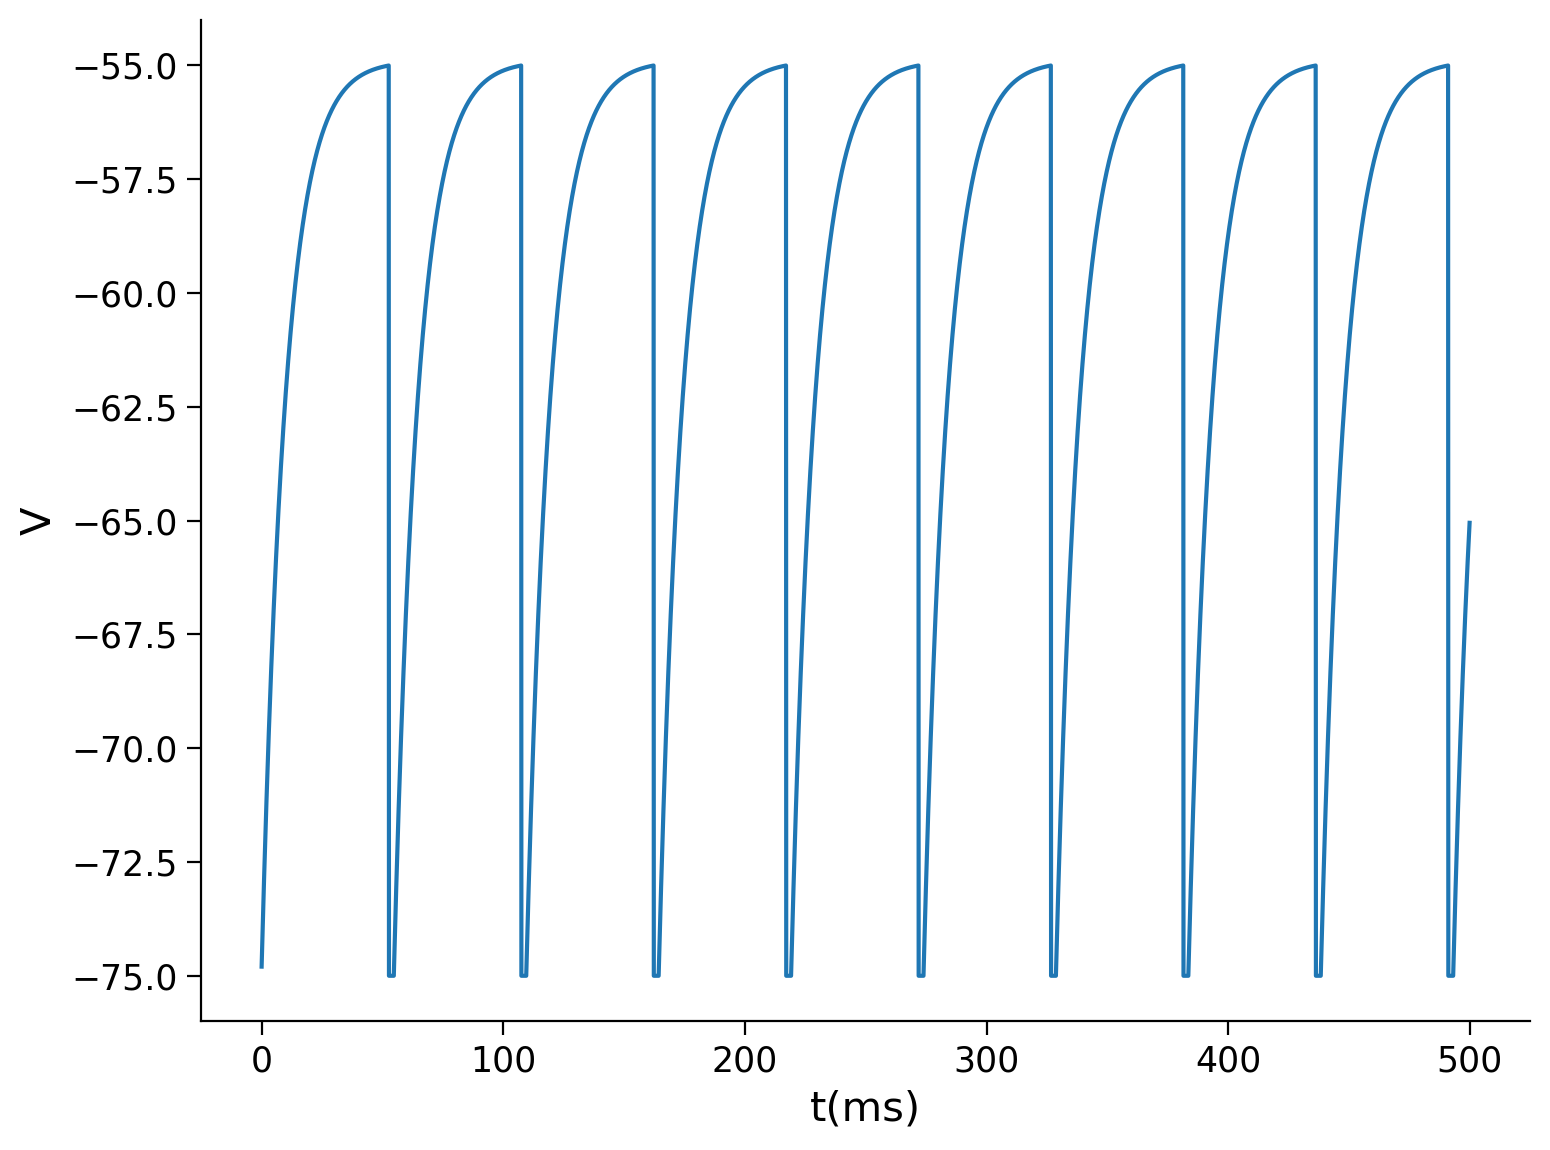

In [4]:
group = LIF(1)
runner = bp.dyn.DSRunner(group,monitors=['V'],inputs=('input',201))
#外界输入电流恒定为20.5mA
runner(500)

plt.plot(runner.mon.ts,runner.mon.V)
plt.xlabel('t(ms)')
plt.ylabel('V')
# plt.show()

In [5]:
def run_LIF(pars, I_inj , duration = 200.):
    group = LIF(I_inj.shape[1],**pars)
    runner = bp.DSRunner(group, monitors=['V', 'spike'], inputs=('input', I_inj,'iter'), progress_bar= False)
    runner.run(duration)
    return runner.mon.ts, np.array(runner.mon.V), np.array(runner.mon.spike)

In [6]:
I_inj = np.ones(int(200./ bm.get_dt()))
print(I_inj.shape)

(2000,)


In [7]:
I_inj = np.ones((2000,10)) * np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ts , V , _= run_LIF(default_pars(), I_inj, duration=2000)

In [8]:
def plot_volt_trace(pars, v, sp, ts):
    """
    Plot trajetory of membrane potential for a single neuron

    Expects:
    pars   : parameter dictionary
    v      : volt trajetory
    sp     : spike train
    ts     : time points

    Returns:
    figure of the membrane potential trajetory for a single neuron
    """

    V_th = pars['V_th']
    dt = ts[1] - ts[0]
    if sp.size:
        v[sp] += 30  # draw nicer spikes

    plt.plot(ts, v, 'b')
    plt.axhline(V_th, 0, 1, color='k', ls='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
               loc=[1.05, 0.75])
    plt.ylim([-80, -40])

---
# Section 2: Response of an LIF model to different types of input currents
In the following section, we will learn how to inject direct current and white noise to study the response of an LIF neuron.

## Section 2.1: Direct current (DC)

### Interactive Demo: Parameter exploration of DC input amplitude 
Here's an interactive demo that shows how the LIF neuron behavior changes for DC input with different amplitudes.

How much DC is needed to reach the threshold (rheobase current)? How does the membrane time constant affect the frequency of the neuron?

In [9]:
# to_remove explanation

"""
1. As we increase the current, we observe that at 210 pA we cross the threshold.

2. As we increase the membrane time constant (slower membrane), the firing rate
is decreased because the membrane needs more time to reach the threshold after
the reset.
""";

In [10]:
my_layout.width = '450px'
@widgets.interact(
    I_dc=widgets.FloatSlider(100., min=50., max=350., step=10.,
                               layout=my_layout),
    tau_m=widgets.FloatSlider(10., min=2., max=20., step=2.,
                                layout=my_layout)
)

def diff_DC(I_dc=200., tau_m = 10.):
    pars = default_pars()
    pars['tau_m'] = tau_m
    inputs = np.ones((int(200./ bm.get_dt()),1)) * I_dc  # 200 ms
    ts, v, sp= run_LIF(pars, I_inj= inputs)
    plot_volt_trace(pars, v, sp, ts)
    plt.show()

/home/spirit/.local/lib/python3.11/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(FloatSlider(value=100.0, description='I_dc', layout=Layout(width='450px'), max=350.0, mi…

## Section 2.2: Gaussian white noise (GWN) current 

Given the noisy nature of neuronal activity _in vivo_, neurons usually receive complex, time-varying inputs.

To mimic this, we will now investigate the neuronal response when the LIF neuron receives Gaussian white noise $\xi(t)$ with mean 

\begin{equation}
E[\xi(t)]=\mu=0,
\end{equation}

and autocovariance 
\begin{equation}
E[\xi(t)\xi(t+\tau)]=\sigma_\xi^2 \delta(\tau)
\end{equation}

The iterative solution method for this differential equation for noise is as follows: please pay attention to the square root sign.

$$
C_m\frac{dV}{dt} = -g_L(V-E_L) + I+\sigma w(t)
$$

$$
V_{m, t+1}=V_{m, t}+\frac{-g_L\left(V_{m, t}-E_L\right)+I}{C_m} d t+\sigma \sqrt{d t} w_n
$$

Note that the GWN has zero mean, that is, it describes only the fluctuations of the input received by a neuron. We can thus modify our definition of GWN to have a nonzero mean value $\mu$ that equals the DC input, since this is the average input into the cell. The cell below defines the modified gaussian white noise currents with nonzero mean $\mu$.

### Interactive Demo: LIF neuron Explorer for noisy input

The mean of the GWN is the amplitude of DC. Indeed, when $\sigma = 0$, GWN is just a DC.

So the question arises how does $\sigma$ of the GWN affect the spiking behavior of the neuron. For instance we may want to know
- how does the minimum input (i.e. $\mu$) needed to make a neuron spike change with increase in $\sigma$
- how does the spike regularity change with increase in $\sigma$

To get an intuition about these questions you can use the following interactive demo that shows how the LIF neuron behavior changes for noisy input with different amplitudes (the mean $\mu$) and fluctuation sizes ($\sigma$).

In [11]:
def my_GWN(pars, mu, sig, myseed=False):
    """
    Function that generates Gaussian white noise input

    Args:
        pars       : parameter dictionary
        mu         : noise baseline (mean)
        sig        : noise amplitute (standard deviation)
        myseed     : random seed. int or boolean
                     the same seed will give the same
                     random number sequence

    Returns:
        I          : Gaussian white noise input
    """

    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['ts']
    num         = len(mu) if hasattr(mu, "__len__") else 1  # Check if mu is a single value or an array-like
    Lt = range_t.size

    # Set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Generate GWN
    # we divide here by 1000 to convert units to sec.
    I_gwn = mu + sig * np.random.randn(Lt , num) / np.sqrt(dt / 1000.)
    return I_gwn

In [12]:
my_layout.width = '450px'

@widgets.interact(
    mu_gwn=widgets.FloatSlider(200., min=100., max=300., step=5.,
                               layout=my_layout),
    sig_gwn=widgets.FloatSlider(2.5, min=0., max=5., step=.5,
                                layout=my_layout)
)

def diff_GWN_to_LIF(mu_gwn, sig_gwn):
    duration = 100.
    pars = default_pars()
    pars_time = default_time(duration=duration)
    I_GWN = my_GWN(pars_time, mu=mu_gwn, sig=sig_gwn)
    ts, v, sp = run_LIF(pars, I_inj= I_GWN, duration=duration)
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(pars_time['ts'][::3], I_GWN[::3], 'b')
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$I_{GWN}$ (pA)')
    plt.subplot(122)
    plot_volt_trace(pars, v, sp, ts)
    plt.tight_layout()
    plt.show()


interactive(children=(FloatSlider(value=200.0, description='mu_gwn', layout=Layout(width='450px'), max=300.0, …

In [13]:
# to_remove explanation

"""
If we have bigger current fluctuations (increased sigma), the minimum input needed
to make a neuron spike is smaller as the fluctuations can help push the voltage above
threshold.

The standard deviation (or size of current fluctuations) dictates the level of
irregularity of the spikes; the higher the sigma the more irregular the observed
spikes.

""";

## Think!
- As we increase the input average ($\mu$) or the input fluctuation ($\sigma$), the spike count changes. How much can we increase the spike count, and what might be the relationship between GWN mean/std or DC value and spike count? 

- We have seen above that when we inject DC, the neuron spikes in a regular manner (clock like), and this regularity is reduced when GWN is injected. The question is, how irregular can we make the neurons spiking by changing the parameters of the GWN? 

We will see the answers to these questions in the next section but discuss first!

---
# Section 3: Firing rate and spike time irregularity
When we plot the output firing rate as a function of GWN mean or DC value, it is called the input-output transfer function of the neuron (so simply F-I curve).

Spike regularity can be quantified as the **coefficient of variance (CV) of the inter-spike-interval (ISI)**:
\begin{align}
\text{CV}_{\text{ISI}} = \frac{std(\text{ISI})}{mean(\text{ISI})}
\end{align}

A Poisson train is an example of high irregularity, in which $\textbf{CV}_{\textbf{ISI}} \textbf{= 1}$. And for a clocklike (regular) process we have $\textbf{CV}_{\textbf{ISI}} \textbf{= 0}$ because of **std(ISI)=0**.

## Interactive Demo: F-I Explorer for different `sig_gwn`

How does the F-I curve of the LIF neuron change as we increase the $\sigma$ of the GWN? We can already expect that the F-I curve will be stochastic and the results will vary from one trial to another. But will there be any other change compared to the F-I curved measured using DC?

Here's an interactive demo that shows how the F-I curve of a LIF neuron changes for different levels of fluctuation $\sigma$.

In [14]:
pars = default_pars()
T = 1000. # total time to simulate (ms)
pars_time = default_time(duration=T) 
I_mean = np.arange(100., 400., 10.)
I_GWN = my_GWN(pars_time, mu= I_mean, sig= 3., myseed=2024)
print(I_GWN.shape)
_ ,v, rec_spikes = run_LIF(pars, I_inj=I_GWN , duration = T)

(10000, 30)


In [15]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(3.0, min=0., max=6., step=0.2,
                                layout=my_layout)
)
def diff_std_affect_fI(sig_gwn):
    pars = default_pars()
    T = 1000.  # total time to simulate (ms)
    pars_time = default_time(duration=T)  # total time to simulate (ms)
    I_mean = np.arange(100., 400., 10.)
    spk_count = np.zeros(len(I_mean))
    spk_count_dc = np.zeros(len(I_mean))

    neuron_num = len(I_mean)
    I_GWN = my_GWN(pars_time, mu= I_mean, sig=sig_gwn, myseed=2024)
    _ ,v, rec_spikes = run_LIF(pars, I_inj=I_GWN , duration = T)
    _ ,v_dc, rec_sp_dc = run_LIF(pars, I_inj= np.ones(I_GWN.shape) * I_mean, duration= T)
    spk_count    = rec_spikes.sum(axis=0)
    spk_count_dc = rec_sp_dc.sum(axis=0)

    # Plot the F-I curve i.e. Output firing rate as a function of input mean.
    plt.figure()
    plt.plot(I_mean, spk_count, 'k',
             label=r'$\sigma_{\mathrm{GWN}}=%.2f$' % sig_gwn)
    plt.plot(I_mean, spk_count_dc, 'k--', alpha=0.5, lw=4, dashes=(2, 2),
             label='DC input')
    plt.ylabel('Spike count')
    plt.xlabel('Average injected current (pA)')
    plt.legend(loc='best')
    plt.show()


interactive(children=(FloatSlider(value=3.0, description='sig_gwn', layout=Layout(width='450px'), max=6.0, ste…

In [16]:
# to_remove explanation

"""
Discussion: If we use a DC input, the F-I curve is deterministic, and we can
found its shape by solving the membrane equation of the neuron. If we have GWN,
as we increase the sigma, the neuron reaches its threshold using less average injected current.
"""

'\nDiscussion: If we use a DC input, the F-I curve is deterministic, and we can\nfound its shape by solving the membrane equation of the neuron. If we have GWN,\nas we increase the sigma, the neuron reaches its threshold using less average injected current.\n'

As shown above, the F-I curve becomes smoother while increasing the amplitude of the fluctuation ($\sigma$). In addition, the fluctuation can also change the irregularity of the spikes. Let's investigate the effect of $\mu=250$ with $\sigma=0.5$ vs $\sigma=3$.

In [17]:
def my_hists(isi1, isi2, cv1, cv2, sigma1, sigma2):
    """
    Plot histograms of inter-spike intervals (isi) for two spike trains and their coefficients of variation (cv).

    Args:
        isi1 : vector with inter-spike intervals for spike train 1
        isi2 : vector with inter-spike intervals for spike train 2
        cv1  : coefficient of variation for isi1
        cv2  : coefficient of variation for isi2
        sigma1: standard deviation of Gaussian white noise for spike train 1
        sigma2: standard deviation of Gaussian white noise for spike train 2

    Returns:
        None
    """

    # Create a figure with two subplots
    plt.figure(figsize=(11, 4))

    # Define bins for the histograms
    my_bins = np.linspace(10, 30, 20)

    # Plot histogram for isi1
    plt.subplot(121)
    plt.hist(isi1, bins=my_bins, color='b', alpha=0.5)
    plt.xlabel('ISI (ms)')
    plt.ylabel('count')
    plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma1, cv1))

    # Plot histogram for isi2
    plt.subplot(122)
    plt.hist(isi2, bins=my_bins, color='b', alpha=0.5)
    plt.xlabel('ISI (ms)')
    plt.ylabel('count')
    plt.title(r'$\sigma_{GWN}=$%.1f, CV$_{\mathrm{isi}}$=%.3f' % (sigma2, cv2))

    # Adjust subplot layout for better display
    plt.tight_layout()

    # Show the figure
    plt.show()

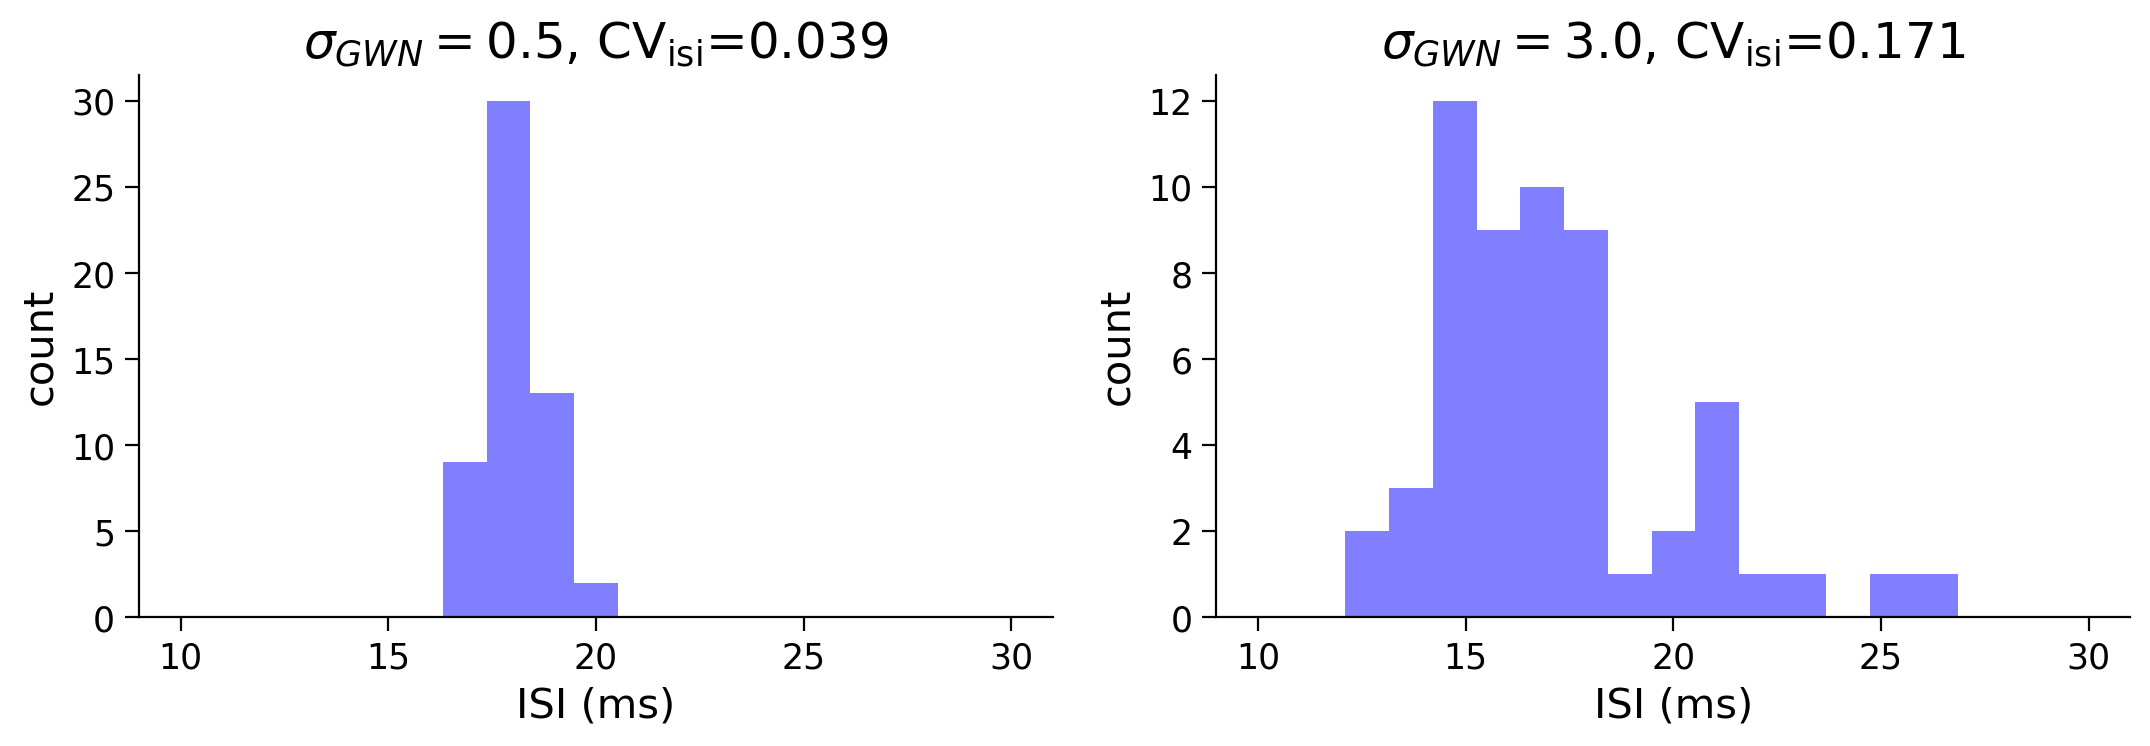

In [18]:
def isi_cv_LIF(spike_times):
    """
    Calculates the inter-spike intervals (isi) and
    the coefficient of variation (cv) for a given spike_train

    Args:
        spike_times : (n, ) vector with the spike times (ndarray)

    Returns:
        isi         : (n-1,) vector with the inter-spike intervals (ms)
        cv          : coefficient of variation of isi (float)

    """

    if len(spike_times) >= 2:
        # Compute isi
        isi = np.diff(spike_times)
        # Compute cv
        cv = isi.std() / isi.mean()
    else:
        isi = np.nan
        cv = np.nan

    return isi, cv


pars = default_pars()
T = 1000.  # total time to simulate (ms)
pars_time = default_time(duration=T)
mu_gwn = 250
sig_gwn1 = 0.5
sig_gwn2 = 3.0

I_GWN1 = my_GWN(pars_time, mu=mu_gwn, sig=sig_gwn1, myseed=2024)
_,_, sp1 = run_LIF(pars, I_inj=I_GWN1, duration=T)

I_GWN2 = my_GWN(pars_time, mu=mu_gwn, sig=sig_gwn2, myseed=2024)
_,_, sp2 = run_LIF(pars, I_inj=I_GWN2, duration=T)

# Uncomment to check your function
isi1, cv1 = isi_cv_LIF(np.where(sp1>0)[0] * bm.get_dt())
isi2, cv2 = isi_cv_LIF(np.where(sp2>0)[0] * bm.get_dt())

my_hists(isi1, isi2, cv1, cv2, sig_gwn1, sig_gwn2)


## Interactive Demo: Spike irregularity explorer for different `sig_gwn`

In the above illustration, we see that the CV of inter-spike-interval (ISI) distribution depends on $\sigma$ of GWN. What about the mean of GWN, should that also affect the CV $_{\rm ISI}$? If yes, how? Does the efficacy of $\sigma$ in increasing the CV $_{\rm ISI}$ depend on $\mu$?

In the following interactive demo, you will examine how different levels of fluctuation $\sigma$ affect the CVs for different average injected currents ($\mu$).

In [19]:
my_layout.width = '450px'

@widgets.interact(
    sig_gwn=widgets.FloatSlider(0.0, min=0., max=10.,
                                step=0.5, layout=my_layout)
)

def diff_std_affect_fI(sig_gwn):
    pars = default_pars()
    T = 1000.  # total time to simulate (ms)
    pars_time = default_time(duration=T)
    I_mean = np.arange(100., 400., 20)
    spk_count = np.zeros(len(I_mean))
    cv_isi = np.empty(len(I_mean))

    

    for idx in range(len(I_mean)):
        I_GWN = my_GWN(pars_time, mu=I_mean[idx], sig=sig_gwn)
        _, _, rec_spikes = run_LIF(pars, I_inj=I_GWN, duration = T)
        rec_spikes = np.where(rec_spikes > 0)[0] * bm.get_dt()
        spk_count[idx] = len(rec_spikes)
        if len(rec_spikes) > 3:
            isi = np.diff(rec_spikes)
            cv_isi[idx] = np.std(isi) / np.mean(isi)

    # Plot the F-I curve i.e. Output firing rate as a function of input mean.
    plt.figure()
    plt.plot(I_mean[spk_count > 5], cv_isi[spk_count > 5], 'bo', alpha=0.5)
    plt.xlabel('Average injected current (pA)')
    plt.ylabel(r'Spike irregularity ($\mathrm{CV}_\mathrm{ISI}$)')
    plt.ylim(-0.1, 1.5)
    plt.grid(True)
    plt.show()


interactive(children=(FloatSlider(value=0.0, description='sig_gwn', layout=Layout(width='450px'), max=10.0, st…